In [26]:
import pandas as pd
import datetime as dt
import numpy as np

import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize
%matplotlib inline

#https://habrahabr.ru/post/207160/
#https://habrahabr.ru/post/210530/
#https://habrahabr.ru/post/207160/
#https://habrahabr.ru/company/ods/blog/327242/

## Читаем данные

In [21]:
df=pd.read_pickle('MG_Sales.pickle',compression='gzip')

## Формируем выборку временного ряда

In [48]:
time_series=pd.DataFrame(data=df[(df['ЦветМеталла']=='Красное золото')&(df['Дата']>=dt.date(2015,1,1))].groupby('Дата')['Количество'].sum())
time_series.index.name='ds'
time_series.columns=['y']
#time_series=time_series.applymap(np.log)

## Отрисовка графика

p-value:  0.0759108370641
есть единичные корни, ряд не стационарен


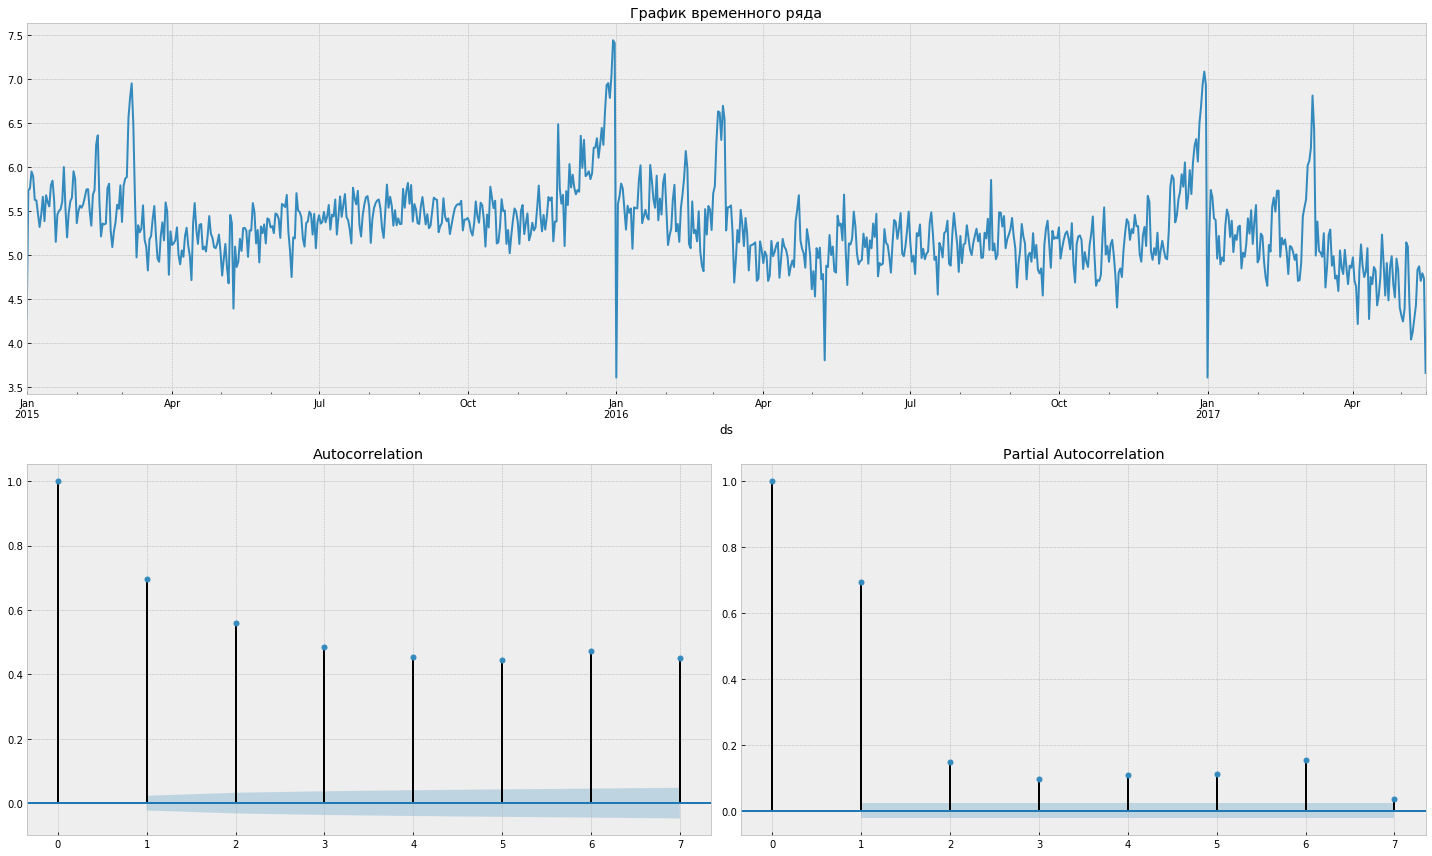

In [64]:
def tsplot(y, lags=None, figsize=(20,12), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('График временного ряда (Среднее по дням)')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        test=sm.tsa.stattools.adfuller(y)
        print ('p-value: ', test[1])
        if test[0]> test[4]['5%']: 
            print ('есть единичные корни, ряд не стационарен')
        else:
            print ('единичных корней нет, ряд стационарен')

        plt.tight_layout()
    return 

tsplot(time_series.y, lags=7)

In [56]:
m = time_series.index[int(len(time_series.index)/2+1)]
r1 = sm.stats.DescrStatsW(time_series[m:])
r2 = sm.stats.DescrStatsW(time_series[:m])
p_value=sm.stats.CompareMeans(r1,r2).ttest_ind()[1]
print ('p-value: ', p_value)
if p_value[0]>0.05:
    print('Ряд близок к стационарному') 
else: 
    print('Ряд не стационарен')

p-value:  [  4.86824535e-39]
Ряд не стационарен


In [55]:
p_value[0]

4.8682453535848474e-39

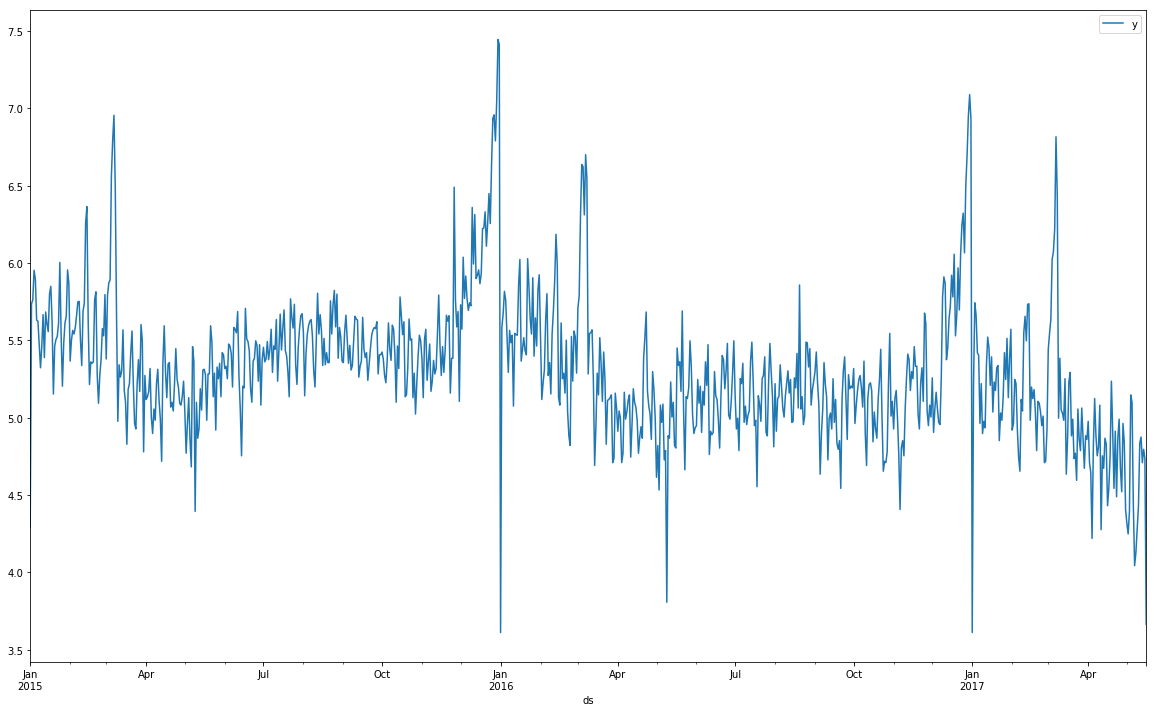

In [65]:
_otg = time_series
_otg.plot(figsize=(20,12))

lag= 365 , p-value:  1.0


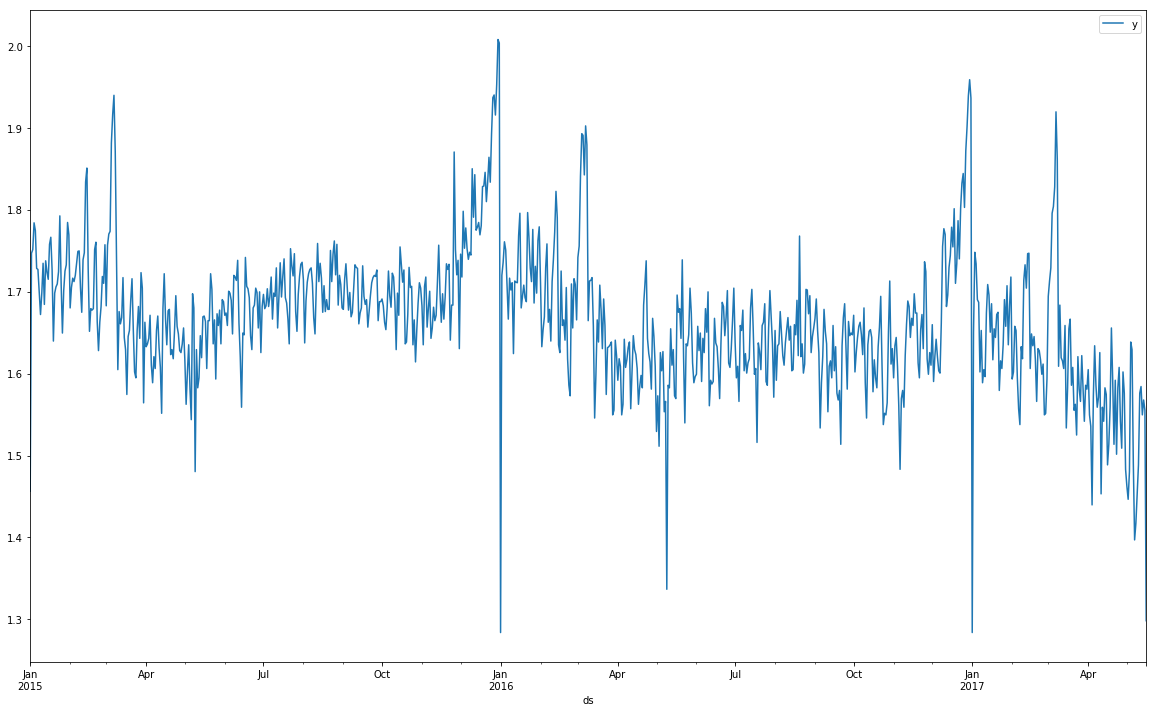

In [93]:
_otg = time_series.applymap(np.log)
_otg.plot(figsize=(20,12))
lag=365
print ('lag=',str(lag),', p-value: ',sm.tsa.adfuller(_otg.y, maxlag=lag)[1])

lag= 365 , p-value:  0.288629405988


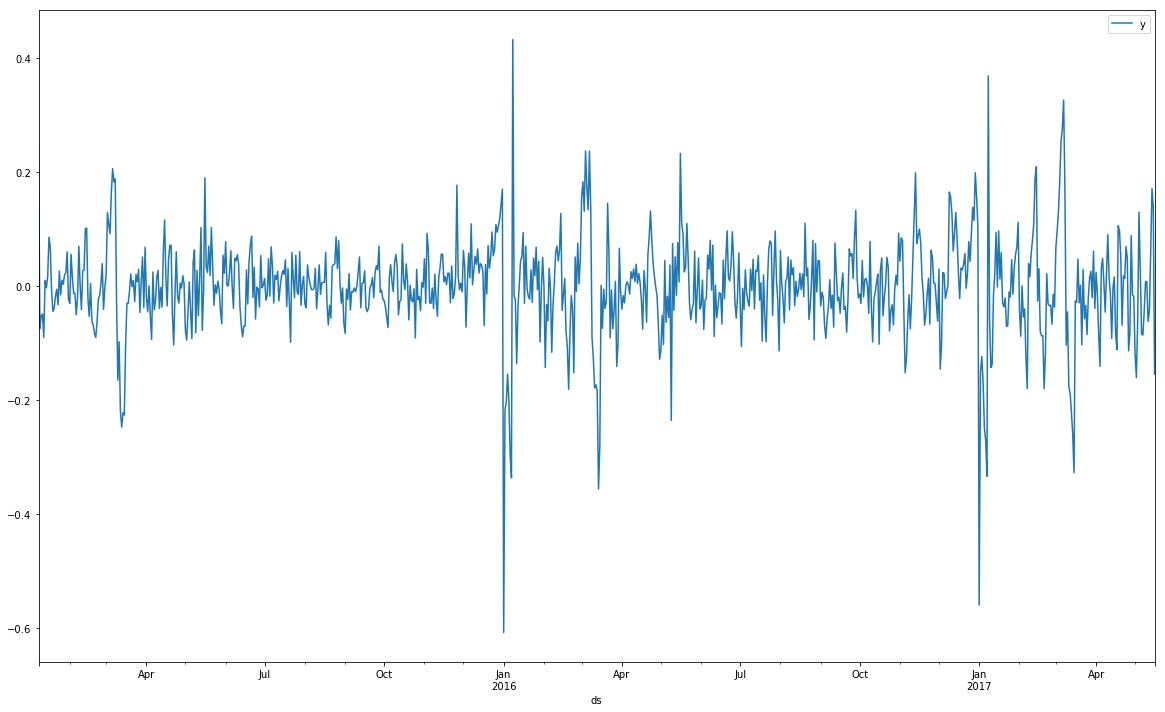

In [94]:
diff1lev = _otg.diff(periods=7).dropna()
diff1lev.plot(figsize=(20,12))

lag=365
print ('lag=',str(lag),', p-value: ',sm.tsa.adfuller(diff1lev.y, maxlag=lag)[1])

C:\Users\tehn-11\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1353: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


lag= 365 , p-value:  0.95853208606


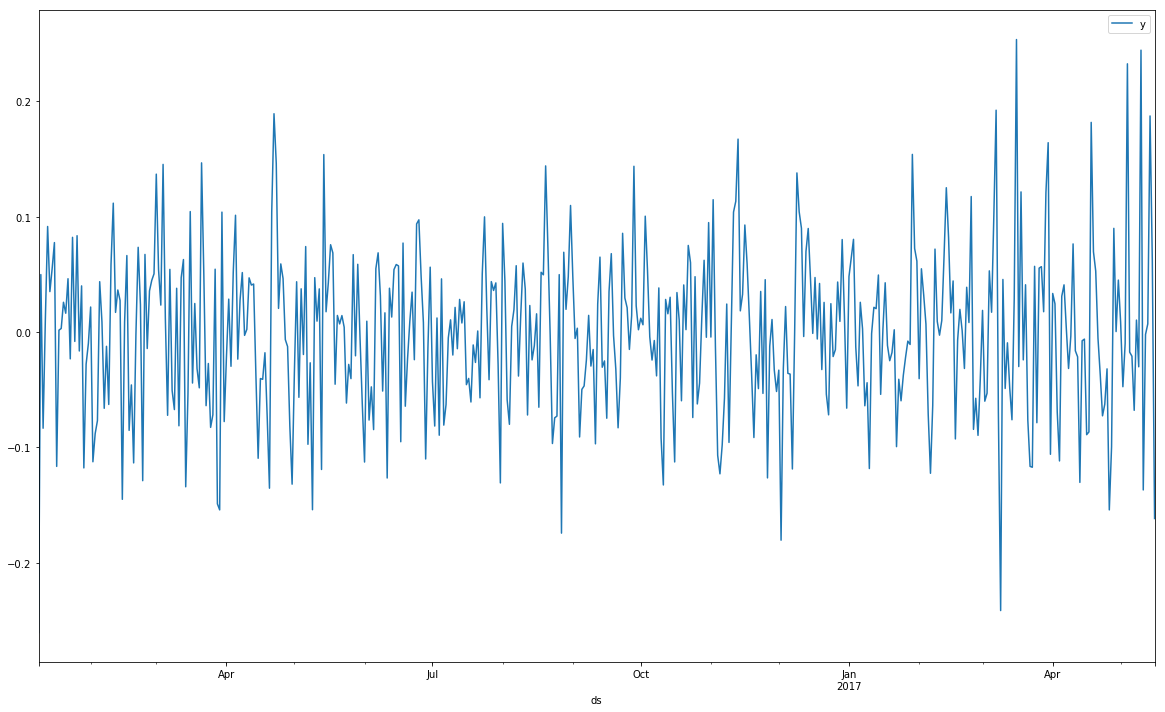

In [101]:
diff1lev_season = diff1lev.diff(366).dropna()
diff1lev_season.plot(figsize=(20,12))

print ('lag=',str(lag),', p-value: ',sm.tsa.adfuller(diff1lev_season.y, maxlag=lag)[1])

In [106]:
diff1lev_season1lev = diff1lev_season.diff().dropna()
print ('p.value: ' , sm.tsa.adfuller(diff1lev_season1lev.y, maxlag=52)[1])

p.value:  4.4554082461e-10


## Модель ARIMA

нам нужно знать ее порядок, состоящий из 2-х параметров:

p — порядок компоненты AR

d — порядок интегрированного ряда

q — порядок компонетны MA

Параметр d есть и он равет 1, осталось определить p и q. Для их определения нам надо изучить авторкорреляционную(ACF) и частично автокорреляционную(PACF) функции для ряда первых разностей.
ACF поможет нам определить q, т. к. по ее коррелограмме можно определить количество автокорреляционных коэффициентов сильно отличных от 0 в модели MA
PACF поможет нам определить p, т. к. по ее коррелограмме можно определить максимальный номер коэффициента сильно отличный от 0 в модели AR.

## Определяем порядок сезонных составляющих P,D,Q.
P — порядок сезонной составляющей SAR(P)

D — порядок интегрирования сезонной составляющей

Q — порядок сезонной составляющей SMA(Q)

Начнем с определения параметра D. Он определет порядок интегрированности сезонной разности, т.е. в нашем случае он равен 1. Для определения P и Q нам как и прежде надо построить коррелограммы ACF и PACF.

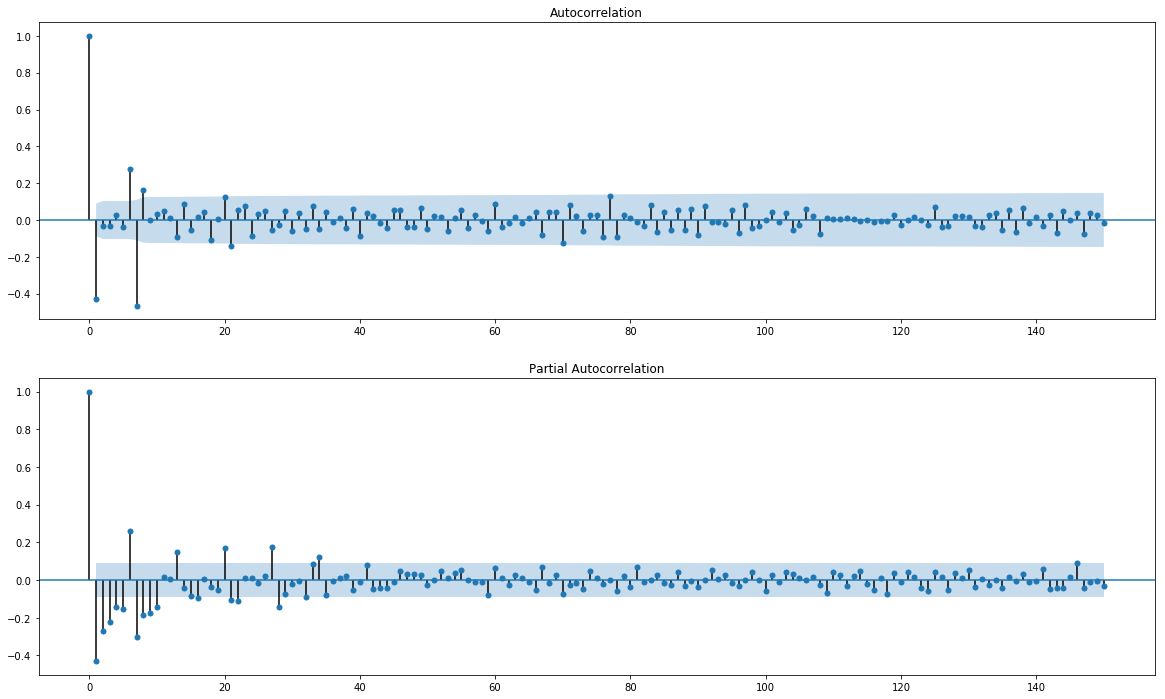

In [108]:
fig = plt.figure(figsize=(20,12))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff1lev_season1lev.values.squeeze(), lags=150, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff1lev_season1lev, lags=150, ax=ax2)

 Частичная автокорреляция — это автокорреляция после снятия авторегрессии предыдущего порядка
 p = 0, т.к. на ней только 0 лаг сильно отличнен от нуля в PACF
    
Параметр q задаётся номером последнего несезонного лага, при котором автокорреляция значима (последнее значение слева которое не попадает в доверительный интервал в графике автокорреляции). 
 q = 1